<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/NLPModel_MultiClass_FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Model with FastText

In this notebook, we are going to use fasttext to predict categories of text.

FastText: https://github.com/facebookresearch/fastText/blob/master/python/README.md

Notebook adapted from: https://github.com/mpuig/textclassification/blob/master/notebook.ipynb

## Installation

In [1]:
! pip install fasttext

## Imports

In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Data

### Fetch data

We are using a relatively large data set of Stack Overflow questions and tags.

In [4]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
categories = df["tags"].unique()

print(f'Number of examples : {len(df)}')
print(f'Number of words in the data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')
print(f'Number of categorie : {len(categories)}')
print()
print(df.head(10))
print()
print(f'Categories: {categories}')


Number of examples : 40000
Number of words in the data: 10286120
Number of categorie : 20

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs

Categories: ['c#' 'asp.net' 'objective-c' '.net' 'python' 'angularjs' 'iphone'
 'ruby-on-rails' 'ios' 'c' 'sql' 'java' 'jquery' 'css' 'c++' 'php'
 'android' 'my

Visualize data

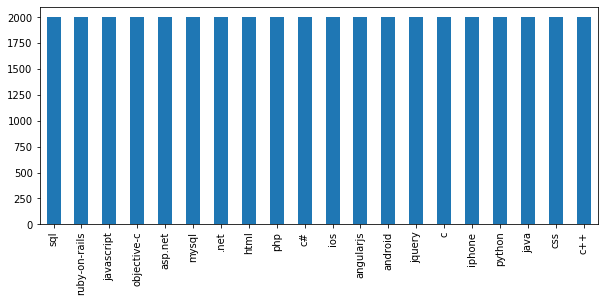

In [5]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

### Text pre-processing

Our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [6]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

print(f'Example text previous cleaning : {df["post"].values[10]}')

df['post'] = df['post'].apply(clean_text)

print(f'Example text previous cleaning : {df["post"].values[10]}')

Example text previous cleaning : when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interf

In [8]:
print(f'Number of words in the cleaning data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')

Number of words in the cleaning data: 3424297


In [0]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

In [31]:
print(f'Number of training examples : {len(train)}')
train.head()

Number of training examples : 28000


,post,tags
38015,getting server tag well formed error th style ...,asp.net
2281,difference lineheight15 lineheight150 css anyo...,css
36629,need simpler way test many sql mysql query lik...,mysql
6087,check 10 minutes passed angularjs question pos...,angularjs
11792,looking bindinglistabouttoremove event item ad...,.net


In [46]:
print(f'Number of test examples : {len(test)}')
test.head()

Number of test examples : 12000


,post,tags
32823,template object property class implemented wor...,c++
16298,copy lines file two patterns store array php c...,php
28505,function used instead event ng model option sa...,angularjs
6689,executing string command c++ string char strin...,c++
26893,asp integrate net 40 possible duplicate classi...,asp.net


In [0]:
def write_fasttext_datafile(filename, df):
  file=open(filename, 'w+')
  for index, row in df.iterrows():
    line = '__label__'+str(row['tags']) + " " + str(row['post'])
    #print(line)
    file.write( str(line) + '\n')
  file.close()

write_fasttext_datafile('fasttext_train.txt', train)
write_fasttext_datafile('fasttext_test.txt', test)

In [60]:
! ls

fasttext_test.txt  fasttext_train.txt  sample_data


In [68]:
! tail fasttext_train.txt

__label__javascript javascript content manipulation example got got random html code html body h1javascript h1 pbla bla p script src sample1js script body html sample1js code var 1234 var b 02 consolelog simple script consolelog b would like know possibility find integers floats sample1js executed reexecute content random generated int float values sum would sample1html file refresh sample1js contain random values b
__label__asp.net best practice synchronous longrunning process working monitoring project monitor different targets including switch router pc specific interval mostly 60 seconds via snmp depending number elements going monitored monitoring processes take long time maybe 30 seconds problem appear number targets 2000 majority monitoring operations take long time occasion monitoring operations overlapit apparently available thread allocate cpu four coresi tried options found gap monitor come queue really start performin fact startmonitoringoperation startmonitoring big interv

## Model training

In [0]:
import fasttext 

model = fasttext.train_supervised('fasttext_train.txt')

In [71]:
sms = """ content manipulation example got got random html code html body h1javascript h1 pbla bla p script src sample1js script body html sample1js code var 1234 var b 02 consolelog simple script consolelog b would like know possibility find integers floats sample1js executed reexecute content random generated int float values sum would sample1html file refresh sample1js contain random values b"""

model.predict(sms)

(('__label__javascript',), array([0.79159403]))

In [70]:
sms = """cannot find files getenv appdata trying locate edit file within appdata ospathisfile getenv appdata + file print found file going open file conn sqlite3connect getenv appdata + file however creates temp file called roamingfile eventhough file appdata directory played around permissions luck also access go straight path eg cusersuserappdata hit brick wall really trying solve look answers hours thanks"""

model.predict(sms, k=3)

(('__label__python', '__label__java', '__label__c#'),
 array([0.34460059, 0.13957433, 0.11433596]))

In [0]:
model.save_model("model_fasttext.bin")

## Model evaluation

In [73]:
model = fasttext.load_model("model_fasttext.bin")

In [75]:
def print_results(N, p, r):
    print("N. examples : \t" + str(N))
    print("Precision@{}\t{:.3f}".format(1, p))
    print("Recall@{}\t{:.3f}".format(1, r))

print_results(*model.test('fasttext_test.txt'))

N. examples : 	12000
Precision@1	0.794
Recall@1	0.794
